Context:
Amazon is a very large online retailing platform and has become increasingly important to the sales and distribution plans of brands in various categories. However, since Amazon is a platform that allows third-party selling, brands are subject to risks of counterfeiting or gray market selling. The top questions brands ask are:

 - 1) To what extent is the brand susceptible to the risk of counterfeiting and gray market selling?
 - 2) What are the that factors increase the risk of becoming a target of gray market sellers?
 - 3) What are other key topics affecting consumer decisions?
 - 4) How do the above trends differ between different product categories?

 
You can choose to tell the story from a single brand's point of view or cover specific categories or use a cross-category approach. Whatever helps to surface the most relevant insights.

 
Deliverable:  

·    An  presentation deck (PowerPoint or google slides) telling the story of the insights you found. You can use as many slides as you want but the allocated time for final presentation is 30 mins including Q&A time. 

and

·    An ipython notebook file (.ipynb) or a script of your code. You can use whichever language you are most comfortable with but we should be able to run the script if required. Include comments and charts as required.  We want you to describe why you're doing what you're doing to reach your insights.  Feel free to describe analytical dead ends as well, but keep it tidy.

Tips:

·     Ratings is not the only "dependent variable". There is no explicit dependent variable to indicate counterfeiting or gray market selling but can be inferred in other ways.

·     Text mining and modeling might lead you in interesting directions.

·     Feel free to manipulate the data, supplement the data with more data, or feature extract/engineer as you see fit.  


### Column Descriptions
column_name&nbsp;&nbsp;&nbsp;&nbsp;          description<br>
asin&nbsp;&nbsp;&nbsp;&nbsp;	                item id assigned by Amazon to the specific SKU<br>
review_post_id&nbsp;&nbsp;&nbsp;&nbsp;	        post_id assigned to the specific product review<br>
body&nbsp;&nbsp;&nbsp;&nbsp;	                text of the consumer review of the product<br>
helpful_count&nbsp;&nbsp;&nbsp;&nbsp;	        number of helpful votes received by the review<br>
num_images&nbsp;&nbsp;&nbsp;&nbsp;	            number of images posted by the reviewer<br>
rating&nbsp;&nbsp;&nbsp;&nbsp;	                rating assigned by the reviewer to the product<br>
date_posted&nbsp;&nbsp;&nbsp;&nbsp;	            date on which review was posted<br>
is_verified_purchase&nbsp;&nbsp;&nbsp;&nbsp;	is it verified amazon prime customer posting the review?<br>
is_vine_voice&nbsp;&nbsp;&nbsp;&nbsp;	        is the customer a vine reviewer?<br>
num_comments&nbsp;&nbsp;&nbsp;&nbsp;	        number of comments on the review<br>
has_video&nbsp;&nbsp;&nbsp;&nbsp;	            does the review contain a video?<br>
category&nbsp;&nbsp;&nbsp;&nbsp;	            product category<br>
list_price&nbsp;&nbsp;&nbsp;&nbsp;	            list price of product<br>
price_low&nbsp;&nbsp;&nbsp;&nbsp;	            lowest observed price for the product on amazon during data capture period<br>
price_high&nbsp;&nbsp;&nbsp;&nbsp;	            highest observed price for the product on amazon during data capture period<br>
is_add_on&nbsp;&nbsp;&nbsp;&nbsp;	            is it an add-on item?<br>
is_prime&nbsp;&nbsp;&nbsp;&nbsp;	            is prime delivery available on the item?<br>
is_prime_pantry&nbsp;&nbsp;&nbsp;&nbsp;	        is this a prime pantry item?<br>
is_prime_exclusive&nbsp;&nbsp;&nbsp;&nbsp;	    is the item exclusive to amazon prime?<br>
is_fresh&nbsp;&nbsp;&nbsp;&nbsp;	            is it an amazon fresh item?<br>
has_sns&nbsp;&nbsp;&nbsp;&nbsp;	                is subscribe and save available on the item?<br>
offer_fulfiller&nbsp;&nbsp;&nbsp;&nbsp;	        shipped by?<br>
offer_merchant&nbsp;&nbsp;&nbsp;&nbsp;	        sold by?<br>
lowest_price_new_conditio&nbsp;&nbsp;&nbsp;&nbsp;n	lowest price at which item is available in new condition<br>
brand&nbsp;&nbsp;&nbsp;&nbsp;	                product brand<br>
num_reviews&nbsp;&nbsp;&nbsp;&nbsp;	            total number of reviews for the item<br>
num_images_pdp&nbsp;&nbsp;&nbsp;&nbsp;	        number of images on the product page<br>

In [1]:
#importing necessary libraries
import pandas as pd
import numpy as np
from IPython.core.display import Image, display
pd.set_option('display.max_colwidth', -1)
pd.set_option('display.max_columns', None)  
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import Counter
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import re
import spacy
import gensim
import nltk
from nltk import FreqDist
from gensim import corpora
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
#loading the dataset
df = pd.read_pickle('/Users/lucky/Large_Project_Files/case_studies/Gartner/counter_dataset')


In [3]:
print("There are ", df.shape[0], " rows and ", df.shape[1], "columns in the dataset.")
print("Total # of columns w/ NaN values: ", df.isnull().any().sum())
df.head(2)

There are  359069  rows and  27 columns in the dataset.
Total # of columns w/ NaN values:  15


,asin,review_post_id,body,helpful_count,num_images,rating,date_posted,is_verified_purchase,is_vine_voice,num_comments,has_video,category,list_price,price_low,price_high,is_add_on,is_prime,is_prime_pantry,is_prime_exclusive,is_fresh,has_sns,offer_fulfiller,offer_merchant,lowest_price_new_condition,brand,num_reviews,num_images_pdp
0,B000I68EL8,RZZQSQMVMPTW3,it feels so comfortable and I can wear it all day!,0,0,5,2017-07-27,True,False,0,False,Women's Shoes,NaN,99.95,99.95,False,False,False,False,False,False,Houser Shoes,Houser Shoes,NaN,Birkenstock,22,8
1,B000I68EL8,RZZI5BHNRQS5Z,Package came with the end missing from the box. Since it’s a gift I will have to update for actual fit.,0,1,3,2017-12-24,True,False,0,False,Women's Shoes,NaN,99.95,99.95,False,False,False,False,False,False,Houser Shoes,Houser Shoes,NaN,Birkenstock,22,8


##### As this is unlabeled dataset, We will have to detect fake product sales, and label those product as not authentic. <br>


In [4]:
df.body.isnull().sum() #There are 271 reviews missing. we will fill in these missing reviews with "no review"
df.body.fillna("No review", inplace = True) #If we drop this rows, we will also information from other columns which might help us detect fake products.

In [5]:
df.brand.isnull().sum()
df.brand.fillna('others', inplace = True)
df.brand.isnull().sum()

0

In [6]:
df.isnull().sum()

asin                          0     
review_post_id                0     
body                          0     
helpful_count                 0     
num_images                    0     
rating                        0     
date_posted                   0     
is_verified_purchase          0     
is_vine_voice                 0     
num_comments                  0     
has_video                     0     
category                      0     
list_price                    346938
price_low                     102686
price_high                    102686
is_add_on                     81357 
is_prime                      81357 
is_prime_pantry               81357 
is_prime_exclusive            81357 
is_fresh                      81357 
has_sns                       81357 
offer_fulfiller               309694
offer_merchant                309694
lowest_price_new_condition    323020
brand                         0     
num_reviews                   2041  
num_images_pdp                0     
d

Imputing missing values:

In [7]:
df[['is_prime','is_add_on', 'is_prime_pantry', 'is_prime_exclusive', 'is_fresh', 'has_sns']] = df[['is_prime','is_add_on', 'is_prime_pantry', 'is_prime_exclusive', 'is_fresh', 'has_sns']].fillna('unknown', inplace = False)

In [8]:
df[['offer_fulfiller', 'offer_merchant']] = df[['offer_fulfiller', 'offer_merchant']].fillna('others', inplace =False)

In [9]:
df.isnull().sum()

asin                          0     
review_post_id                0     
body                          0     
helpful_count                 0     
num_images                    0     
rating                        0     
date_posted                   0     
is_verified_purchase          0     
is_vine_voice                 0     
num_comments                  0     
has_video                     0     
category                      0     
list_price                    346938
price_low                     102686
price_high                    102686
is_add_on                     0     
is_prime                      0     
is_prime_pantry               0     
is_prime_exclusive            0     
is_fresh                      0     
has_sns                       0     
offer_fulfiller               0     
offer_merchant                0     
lowest_price_new_condition    323020
brand                         0     
num_reviews                   2041  
num_images_pdp                0     
d

5 columns still have missing values, we will leave them for now.

We will start by cleaning the body column

In [10]:
# function to plot most frequent terms
def freq_words(x, terms = 30):
    all_words = ' '.join([text for text in x])
    all_words = all_words.split()
    
    fdist = FreqDist(all_words)
    words_df = pd.DataFrame({'word':list(fdist.keys()), 'count':list(fdist.values())})

  # selecting top 20 most frequent words
    d = words_df.nlargest(columns="count", n = terms) 
    plt.figure(figsize=(20,5))
    ax = sns.barplot(data=d, x= "word", y = "count")
    ax.set(ylabel = 'Count')
    plt.show()

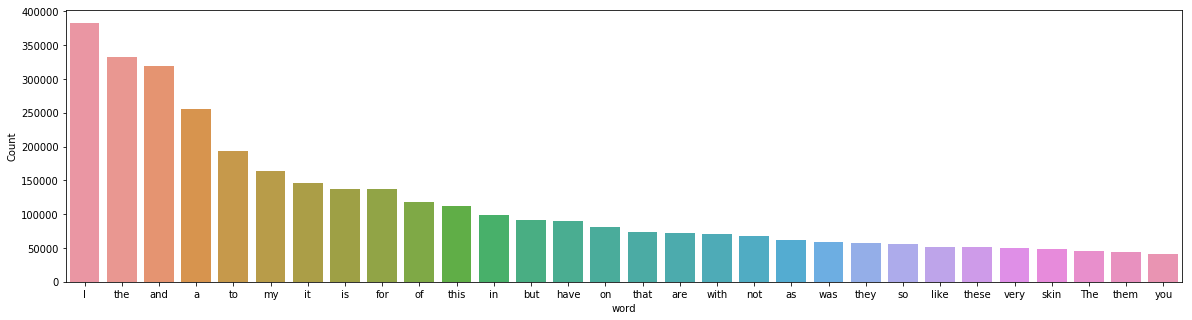

In [11]:
freq_words(df['body'])

Most common words are ‘I’, 'the’, 'and', 'a', ‘to’, so on and so forth. These words are not so important for our task and they do not tell any story. We’ have to get rid of these kinds of words. Before that let’s remove the punctuations and numbers from our text data.

In [12]:
# remove unwanted characters, numbers and symbols
df['body'] = df['body'].str.replace("[^a-zA-Z#]", " ")

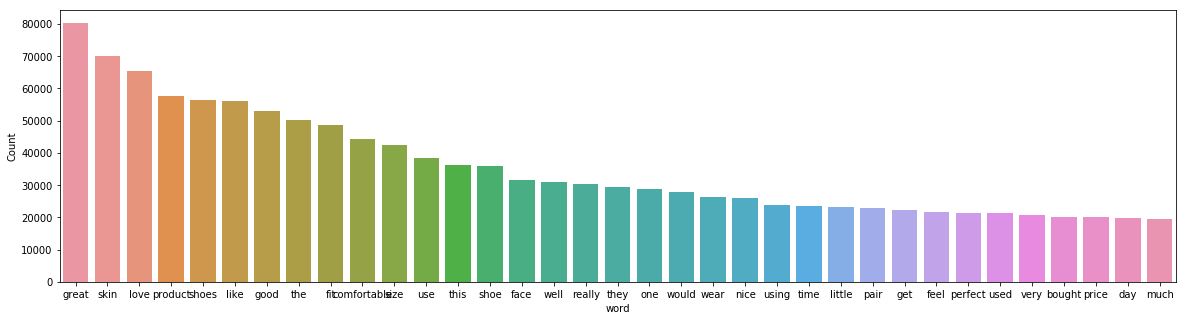

In [13]:
#Let’s try to remove the stopwords and short words (<2 letters) from the reviews.
from nltk.corpus import stopwords
stop_words = stopwords.words('english')

# function to remove stopwords
def remove_stopwords(rev):
    rev_new = " ".join([i for i in rev if i not in stop_words])
    return rev_new

# remove short words (length < 3)
df['body'] = df['body'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>2]))

# remove stopwords from the text
body = [remove_stopwords(r.split()) for r in df['body']]

# make entire text lowercase
body = [r.lower() for r in body]

freq_words(body, 35)

In [14]:
nlp = spacy.load('en', disable=['parser', 'ner'])

def lemmatization(texts, tags=['NOUN', 'ADJ']): # filter noun and adjective
    output = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        output.append([token.lemma_ for token in doc if token.pos_ in tags])
    return output



In [15]:
tokenized_body = pd.Series(body).apply(lambda x: x.split())
print(tokenized_body[0])

['feels', 'comfortable', 'wear', 'day']


In [16]:
body_2 = lemmatization(tokenized_body)
print(body_2[0]) # print lemmatized review

['comfortable', 'wear', 'day']


In [17]:
df['comments'] = body_2

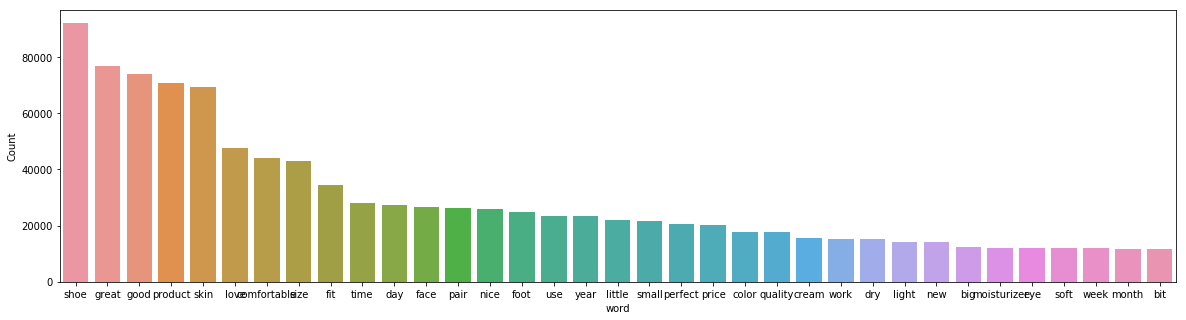

In [18]:
reviews_3 = []
for i in range(len(body_2)):
    reviews_3.append(' '.join(body_2[i]))

df['reviews'] = reviews_3

freq_words(df['reviews'], 35)

In [19]:
df.head(2) #At this point we have 2 new columns comments and reviews

,asin,review_post_id,body,helpful_count,num_images,rating,date_posted,is_verified_purchase,is_vine_voice,num_comments,has_video,category,list_price,price_low,price_high,is_add_on,is_prime,is_prime_pantry,is_prime_exclusive,is_fresh,has_sns,offer_fulfiller,offer_merchant,lowest_price_new_condition,brand,num_reviews,num_images_pdp,comments,reviews
0,B000I68EL8,RZZQSQMVMPTW3,feels comfortable and can wear all day,0,0,5,2017-07-27,True,False,0,False,Women's Shoes,NaN,99.95,99.95,False,False,False,False,False,False,Houser Shoes,Houser Shoes,NaN,Birkenstock,22,8,"[comfortable, wear, day]",comfortable wear day
1,B000I68EL8,RZZI5BHNRQS5Z,Package came with the end missing from the box Since gift will have update for actual fit,0,1,3,2017-12-24,True,False,0,False,Women's Shoes,NaN,99.95,99.95,False,False,False,False,False,False,Houser Shoes,Houser Shoes,NaN,Birkenstock,22,8,"[package, end, missing, box, gift, update, actual, fit]",package end missing box gift update actual fit


In [20]:
print(df.body.isnull().sum()) # Great no missing values in body column.
print("There are ",df[df.body.str.contains('fake')].shape[0], "reviews that have word 'fake' in them.")

0
There are  1448 reviews that have word 'fake' in them.


In [21]:
print(df.body.isnull().sum()) # Great no missing values in body column.
print("There are ",df[df.reviews.str.contains('fake')].shape[0], "reviews that have word 'fake' in them.")

0
There are  1592 reviews that have word 'fake' in them.


In [22]:
df.head(2)

,asin,review_post_id,body,helpful_count,num_images,rating,date_posted,is_verified_purchase,is_vine_voice,num_comments,has_video,category,list_price,price_low,price_high,is_add_on,is_prime,is_prime_pantry,is_prime_exclusive,is_fresh,has_sns,offer_fulfiller,offer_merchant,lowest_price_new_condition,brand,num_reviews,num_images_pdp,comments,reviews
0,B000I68EL8,RZZQSQMVMPTW3,feels comfortable and can wear all day,0,0,5,2017-07-27,True,False,0,False,Women's Shoes,NaN,99.95,99.95,False,False,False,False,False,False,Houser Shoes,Houser Shoes,NaN,Birkenstock,22,8,"[comfortable, wear, day]",comfortable wear day
1,B000I68EL8,RZZI5BHNRQS5Z,Package came with the end missing from the box Since gift will have update for actual fit,0,1,3,2017-12-24,True,False,0,False,Women's Shoes,NaN,99.95,99.95,False,False,False,False,False,False,Houser Shoes,Houser Shoes,NaN,Birkenstock,22,8,"[package, end, missing, box, gift, update, actual, fit]",package end missing box gift update actual fit


#### After cleaning body column, we are able to detect more rows which contains word "fake" in them and we have also introduced two new columns ['comments' and 'reviews'] which are cleaner version of body . <br>
Having "fake" word in the review not necessarily mean that the review is negative or it's a fake product.<br> For example: <br>
Review review_post_id[RAS5ZP7RWM0TX] (shownbelow) contains word "fake", but it's actually a positive review with 5 star rating. So, we can not label these kind of reviews as negative reviews. Let's try and see if we can identify these kind of reviews using sentiment analysis.

In [23]:
df[df['review_post_id'] == 'RAS5ZP7RWM0TX']

,asin,review_post_id,body,helpful_count,num_images,rating,date_posted,is_verified_purchase,is_vine_voice,num_comments,has_video,category,list_price,price_low,price_high,is_add_on,is_prime,is_prime_pantry,is_prime_exclusive,is_fresh,has_sns,offer_fulfiller,offer_merchant,lowest_price_new_condition,brand,num_reviews,num_images_pdp,comments,reviews
122,B000I68EL8,RAS5ZP7RWM0TX,bit expensive Thought was fake first but they are authentic Good for long casual and versatile wear Can wear with literally anything,0,0,4,2017-08-28,True,False,0,False,Women's Shoes,NaN,99.95,99.95,False,False,False,False,False,False,Houser Shoes,Houser Shoes,NaN,Birkenstock,22,8,"[expensive, thought, fake, first, authentic, good, long, casual, versatile, wear, anything]",expensive thought fake first authentic good long casual versatile wear anything


### Using VADER to handle sentiment analysis: <br>
-Sentiment analysis is simply the process of working out (statistically) whether a piece of text is positive, negative or neutral. <br>
VADER is easy-to-use and powerful package

In [24]:
analyzer = SentimentIntensityAnalyzer()
df['vader_neg'] = 0
df['vader_pos'] = 0
df['vader_neu'] = 0
df['vader_compound'] = 0
for i, q in enumerate(df.reviews.values):
    vs = analyzer.polarity_scores(q)
    df.iloc[i, -4] = vs['neg']
    df.iloc[i, -3] = vs['pos']
    df.iloc[i, -2] = vs['neu']
    df.iloc[i, -1] = vs['compound']

In [25]:
df.head(2)

,asin,review_post_id,body,helpful_count,num_images,rating,date_posted,is_verified_purchase,is_vine_voice,num_comments,has_video,category,list_price,price_low,price_high,is_add_on,is_prime,is_prime_pantry,is_prime_exclusive,is_fresh,has_sns,offer_fulfiller,offer_merchant,lowest_price_new_condition,brand,num_reviews,num_images_pdp,comments,reviews,vader_neg,vader_pos,vader_neu,vader_compound
0,B000I68EL8,RZZQSQMVMPTW3,feels comfortable and can wear all day,0,0,5,2017-07-27,True,False,0,False,Women's Shoes,NaN,99.95,99.95,False,False,False,False,False,False,Houser Shoes,Houser Shoes,NaN,Birkenstock,22,8,"[comfortable, wear, day]",comfortable wear day,0.000,0.623,0.377,0.5106
1,B000I68EL8,RZZI5BHNRQS5Z,Package came with the end missing from the box Since gift will have update for actual fit,0,1,3,2017-12-24,True,False,0,False,Women's Shoes,NaN,99.95,99.95,False,False,False,False,False,False,Houser Shoes,Houser Shoes,NaN,Birkenstock,22,8,"[package, end, missing, box, gift, update, actual, fit]",package end missing box gift update actual fit,0.175,0.429,0.397,0.4939


At this point we have introduced 4 new columns vader_neg, pos, neu and compound. compound is weighted number between -1 to 1. <0 means more negative and >0 means overall positive.

In [26]:
#checking vader_compound of the positive review which contains word "fake"
df[df['review_post_id'] == 'RAS5ZP7RWM0TX']

,asin,review_post_id,body,helpful_count,num_images,rating,date_posted,is_verified_purchase,is_vine_voice,num_comments,has_video,category,list_price,price_low,price_high,is_add_on,is_prime,is_prime_pantry,is_prime_exclusive,is_fresh,has_sns,offer_fulfiller,offer_merchant,lowest_price_new_condition,brand,num_reviews,num_images_pdp,comments,reviews,vader_neg,vader_pos,vader_neu,vader_compound
122,B000I68EL8,RAS5ZP7RWM0TX,bit expensive Thought was fake first but they are authentic Good for long casual and versatile wear Can wear with literally anything,0,0,4,2017-08-28,True,False,0,False,Women's Shoes,NaN,99.95,99.95,False,False,False,False,False,False,Houser Shoes,Houser Shoes,NaN,Birkenstock,22,8,"[expensive, thought, fake, first, authentic, good, long, casual, versatile, wear, anything]",expensive thought fake first authentic good long casual versatile wear anything,0.196,0.297,0.506,0.1531


In the above review we have word "fake", but it actually an positive review. Vader gave this review and average weight of 0.15

### For the purpose of this case study i am going to set following threshold for labeling product as fake products: <br>
- Words such as ['fake', 'conterfeit', 'replica'] in reviews columns and rating below 3 star.
- If specific product appears more than 5 times (which basically means 5 users complained about product being fake and rated it beloe 3 stars) in fake dataset(dataset we are going to create below based on above threshold) we will label that specific product as fake in the whole dataset.

In [27]:
fake = df[((df.reviews.str.contains('fake')) | (df.reviews.str.contains('counterfeit')) | (df.reviews.str.contains('replicas'))) & ((df['rating'] < 3))]


In [28]:
fake.shape

(1328, 33)

In [29]:
print("Average Vader compound for fake dataset: ", fake.vader_compound.mean() )

Average Vader compound for fake dataset:  -0.3938019578313232


In [30]:
fake_ = Counter(fake.asin) #counts number of time each asin appears in fake dataset
fake_products = []
for k,v in fake_.items():
    if v >=5:
        fake_products.append(k)

In [31]:
len(fake_products) #We have 54 products that according to our threshold are fake

54

Let's label these products fake in df dataset.

In [32]:
df['fake_detection'] = [1 if x in fake_products else 0 for x in df['asin']]

In [33]:
df.fake_detection.value_counts()/len(df)

0    0.902726
1    0.097274
Name: fake_detection, dtype: float64

Nexy Steps: <br>
- Create copy of df()
- Drop [body, comments and reviews] columns as we vader columns will represent the text data present in these columns
- Impute missing values in the rest of the columns
- use random forest to predict 1s (bad product) and using feautre importance show what factors increase the risk of becoming a target of gray market sellers.

In [34]:
df.head()

,asin,review_post_id,body,helpful_count,num_images,rating,date_posted,is_verified_purchase,is_vine_voice,num_comments,has_video,category,list_price,price_low,price_high,is_add_on,is_prime,is_prime_pantry,is_prime_exclusive,is_fresh,has_sns,offer_fulfiller,offer_merchant,lowest_price_new_condition,brand,num_reviews,num_images_pdp,comments,reviews,vader_neg,vader_pos,vader_neu,vader_compound,fake_detection
0,B000I68EL8,RZZQSQMVMPTW3,feels comfortable and can wear all day,0,0,5,2017-07-27,True,False,0,False,Women's Shoes,NaN,99.95,99.95,False,False,False,False,False,False,Houser Shoes,Houser Shoes,NaN,Birkenstock,22,8,"[comfortable, wear, day]",comfortable wear day,0.000,0.623,0.377,0.5106,1
1,B000I68EL8,RZZI5BHNRQS5Z,Package came with the end missing from the box Since gift will have update for actual fit,0,1,3,2017-12-24,True,False,0,False,Women's Shoes,NaN,99.95,99.95,False,False,False,False,False,False,Houser Shoes,Houser Shoes,NaN,Birkenstock,22,8,"[package, end, missing, box, gift, update, actual, fit]",package end missing box gift update actual fit,0.175,0.429,0.397,0.4939,1
2,B000I68EL8,RZN7OFKFGQO0N,Birkenstock amazing shoe wish had ten pairs,0,0,5,2017-05-31,True,False,0,False,Women's Shoes,NaN,99.95,99.95,False,False,False,False,False,False,Houser Shoes,Houser Shoes,NaN,Birkenstock,22,8,"[birkenstock, amazing, shoe, pair]",birkenstock amazing shoe pair,0.000,0.559,0.441,0.5859,1
3,B000I68EL8,RZLEB1YTRQQ33,Delivered advertised shoe looks fits expected Leather color seems bit lighter than one seen store but still satisfactory,0,0,5,2018-06-24,True,False,0,False,Women's Shoes,NaN,99.95,99.95,False,False,False,False,False,False,Houser Shoes,Houser Shoes,NaN,Birkenstock,22,8,"[advertised, shoe, expected, leather, color, light, store, satisfactory]",advertised shoe expected leather color light store satisfactory,0.000,0.263,0.737,0.3612,1
4,B000I68EL8,RZI71N4TZRCMD,Second pair have had Nothing beats them,0,0,5,2017-02-05,True,False,0,False,Women's Shoes,NaN,99.95,99.95,False,False,False,False,False,False,Houser Shoes,Houser Shoes,NaN,Birkenstock,22,8,"[second, pair, nothing, beat]",second pair nothing beat,0.000,0.000,1.000,0.0000,1


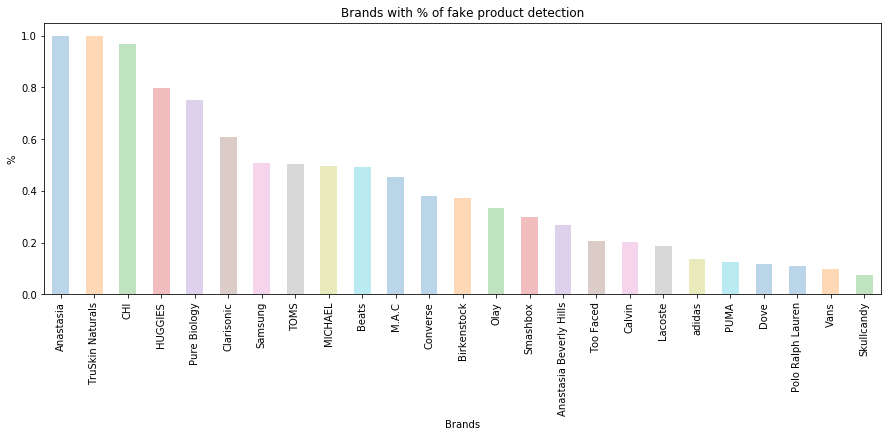

In [118]:
(df[df['fake_detection'] == 1].brand.value_counts()/df.brand.value_counts()).sort_values(ascending = False).head(25).plot(kind = 'bar',alpha=.30, figsize = (15, 5))
plt.title("Brands with % of fake product detection")
plt.xlabel("Brands")
plt.ylabel('%');

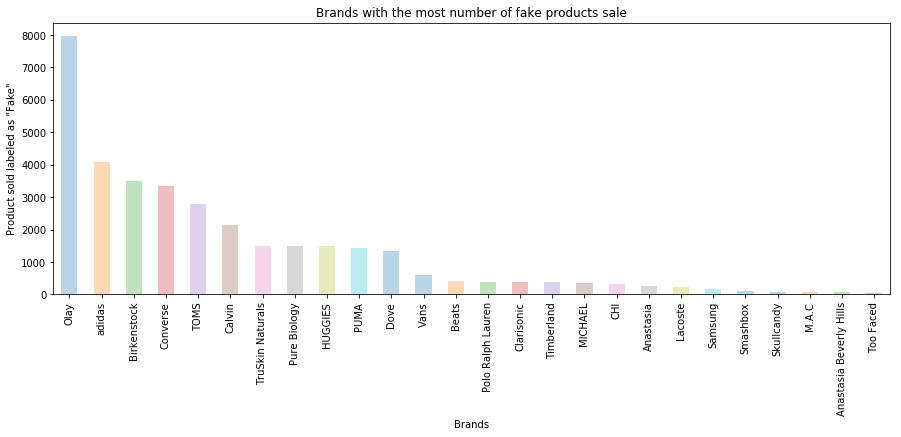

In [122]:
df[df['fake_detection'] == 1].brand.value_counts().plot(kind = 'bar', alpha=.30, figsize = (15, 5))
plt.title("Brands with the most number of fake products sale")
plt.xlabel("Brands")
plt.ylabel('Product sold labeled as "Fake"');

Olay, adidas, Birkenstock are brands with the most number of fake product sold.